In [1]:
import os
import re
import random
from operator import itemgetter
from typing import List
from pathlib import Path
from joblib import dump, load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from scipy.stats import randint, uniform, loguniform
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score, roc_auc_score

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

SEED = 42

In [2]:
# nltk.download('stopwords')
# nltk.download('wordnet')

# The dataset

In [3]:
loading_data_params = {"remove": ("headers", "footers", "quotes"),
                       "return_X_y": True,
                       "random_state": SEED}

train = fetch_20newsgroups(data_home="data/train", subset="train")
X_train, y_train = fetch_20newsgroups(data_home="data/train", subset="train", **loading_data_params)
X_test, y_test = fetch_20newsgroups(data_home="data/test", subset="test", **loading_data_params)

## Content

In [4]:
print(train.DESCR[26:395])
print(train.DESCR[846:1050])


The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

**Data Set Characteristics:**

=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1
Features                  text


In [5]:
labels = dict(zip(range(20), train.target_names))
pd.DataFrame.from_dict(labels, orient="index", columns=["target_name"])

,target_name
0,alt.atheism
1,comp.graphics
2,comp.os.ms-windows.misc
3,comp.sys.ibm.pc.hardware
4,comp.sys.mac.hardware
5,comp.windows.x
6,misc.forsale
7,rec.autos
8,rec.motorcycles
9,rec.sport.baseball


In [11]:
# for convenient data browsing
def display_random_sample(data, target_variable, labels, n_samples=1, target_class=None):
    """Display random sample(s) from all the data or from a selected class"""
    
    if target_class is not None:
        filtered_indices = [i for i, label in enumerate(target_variable) if label == target_class]
        if not filtered_indices:
            print(f"No samples found for class {target_class}")
            return
        data = list(itemgetter(*filtered_indices)(data))
        target_variable = list(itemgetter(*filtered_indices)(target_variable))
    
    sampled_indices = random.sample(range(len(data)), k=n_samples)
    
    for i in sampled_indices:
        label = labels[target_variable[i]]
        print(f"Label: {label}\n\nMessage:\n{data[i]}\n")

display_random_sample(X_train, y_train, labels, n_samples=1, target_class=None)

Label: rec.autos

Message:
Hi Netters
	I want to know if 13500 (w/o tax) is a good deal for 1993 Mazda 626 DX
How is the performance review so far on Mazda 626. Is it a good buy?
Please reply to me as I don't read this group often.

Thanks In advance
Ravi
--
Ravi Kiran Puvvala		| "The purpose of education is not merely, 
ravi@merlin.dev.cdx.mot.com	|  the assimilation of facts but blow all 
Motorola Codex, Boston  MA 	|  the money" - Ravi Puvvala



**Problemy**:
* puste napisy
* n3jpx, x11r5
* adresy e-maile, numery telefon, faxu
* nazwy instytucji/firm, adresy

## Initial cleaning

In [12]:
def check_empty_samples(X_train, X_test):
    """"""
    empty_train_indices = [idx for idx, string in enumerate(X_train) if string in ["", " "]]
    empty_test_indices = [idx for idx, string in enumerate(X_test) if string in ["", " "]]
    
    return empty_train_indices, empty_test_indices

empty_train_indices, empty_test_indices = check_empty_samples(X_train, X_test)
print(f"X_train: {len(empty_train_indices)} empty strings\nX_test: {len(empty_test_indices)} empty strings")

X_train: 226 empty strings
X_test: 163 empty strings


In [13]:
def remove_empty_samples(X: List[str], y: np.ndarray, indices: List[int]):
    """Remove samples with empty data"""
    # X, y = X.copy(), y.copy()
    for idx in reversed(indices):
        del X[idx]
        y = np.delete(y, idx)

    return X, y
    
X_train, y_train = remove_empty_samples(X_train, y_train, empty_train_indices)
X_test, y_test = remove_empty_samples(X_test, y_test, empty_test_indices)

empty_train_indices, empty_test_indices = check_empty_samples(X_train, X_test)
print(f"X_train: {len(empty_train_indices)} empty strings\nX_test: {len(empty_test_indices)} empty strings")

X_train: 0 empty strings
X_test: 0 empty strings


## Class distribution

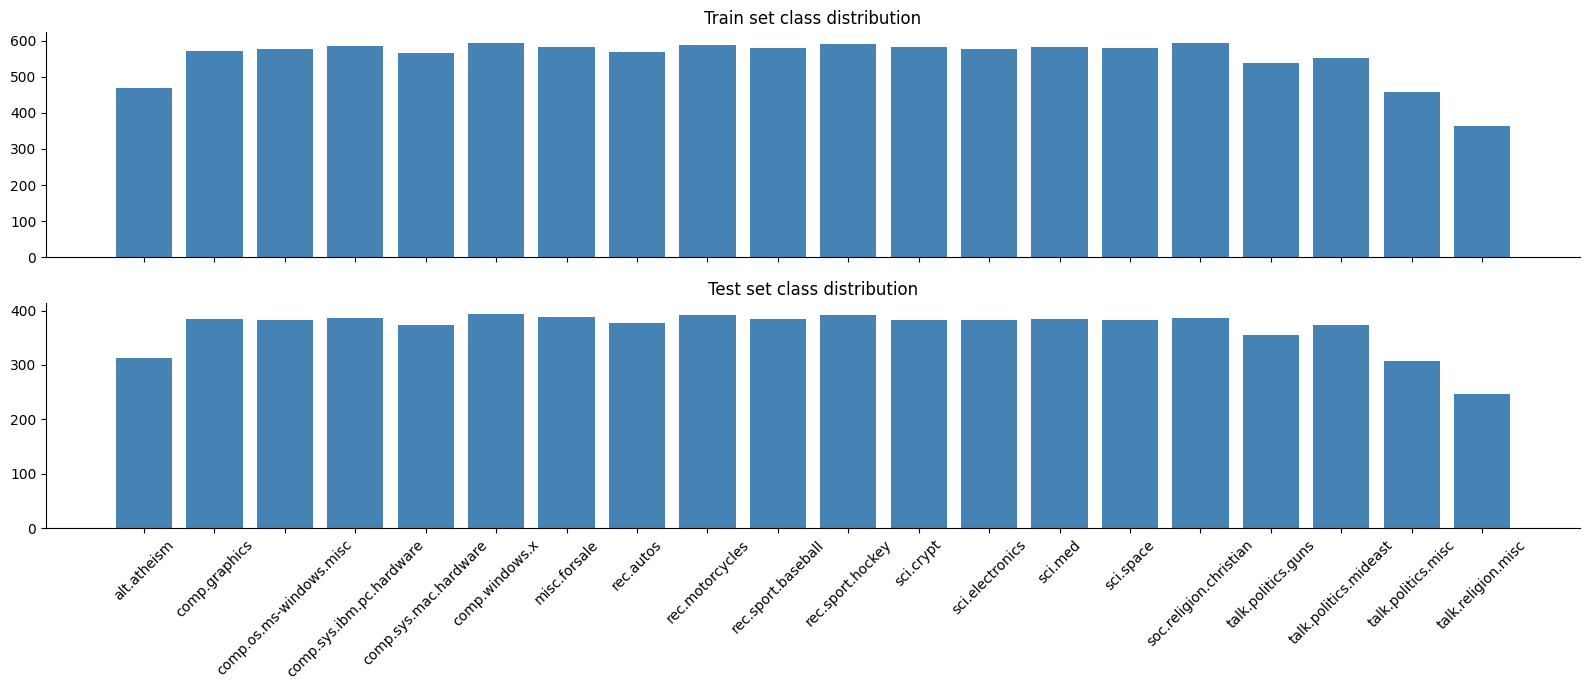

In [14]:
unique, counts_train = np.unique(y_train, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)

fig, axs = plt.subplots(2, 1, figsize=(16, 7), sharex=True)
axs[0].bar(train.target_names, counts_train, color="steelblue")
axs[0].set_title("Train set class distribution")
axs[1].bar(train.target_names, counts_test, color="steelblue")
axs[1].set_title("Test set class distribution")
axs[1].set_xticks(ticks=unique, labels=train.target_names, rotation=45)
plt.tight_layout();

# Data preparing and ML experiments

## Data preparing

In [21]:
class DataCleaner:

    def __init__(self,
                 to_remove_patterns: List[str],
                 to_remove_words: List[str] = [],
                 token_pattern: str = r"(?u)\b\w[\w']*\b"
                ):
        
        self.to_remove_patterns = to_remove_patterns
        self.to_remove_words = to_remove_words
        self.token_pattern = token_pattern
        self.stop_words = stopwords.words("english")
        self.lemmatizer = WordNetLemmatizer()

    def remove_substrings_from_patterns(self):
        "Remove substrings found as unwanted token patterns."
        for pattern in self.to_remove_patterns:
            self.data = [pattern.sub("", message) for message in self.data]

        return self
    
    def remove_substring_from_list(self):
        """Tokenize, remove unwanted words and lowercase all."""
        
        pre_cleaned = []
        
        for message in self.data:
            tokens = re.findall(self.token_pattern, message)
            cleaned_message = [w.lower() for w in tokens if w.lower() not in self.stop_words + self.to_remove_words]
            pre_cleaned.append(cleaned_message)

        self.data = pre_cleaned
    
        return self       
    
    def lemmatize_data(self):
        """Lemmatize tokenized messages and join into strings."""
    
        for i in range(len(self.data)):
            lemmatized_message = [self.lemmatizer.lemmatize(token) for token in self.data[i]]
            self.data[i] = " ".join(lemmatized_message)
    
        return self

    def transform(self, data: List[str]):
        self.data = data.copy()
        self.remove_substrings_from_patterns()
        self.remove_substring_from_list()
        self.lemmatize_data()
        
        return self.data

In [23]:
email_pattern = re.compile("[\w\.]+@\w+\.\w+[\w\.]*")
nntp_pattern = re.compile(r"\b\w*(?:nntp|NNTP)\w*\b")
num_seq_pattern = re.compile(r'\b\d+\b')
num_with_letters = re.compile(r'\b(?=\w*\d)(?=\w*[a-zA-Z])\w{3,}\b')
words_to_remove = ["re", "subject", "organization", "lines", "from", "date",
                   "references", "message", "id", "voice", "fax", "email", "mail",
                   "i'm", "i've", "i'd", "can't", "can"]

cleaner = DataCleaner(to_remove_patterns=[email_pattern,
                                          nntp_pattern,
                                          num_seq_pattern,
                                          num_with_letters],
                      to_remove_words=words_to_remove)

cleaned_X_train = cleaner.transform(X_train)
cleaned_X_test = cleaner.transform(X_test)

In [24]:
vectorizer = TfidfVectorizer()
print(f"Number of unigram features before cleaning: {len(vectorizer.fit(X_train).get_feature_names_out())}\nAfter cleaning and lemmatization: {len(vectorizer.fit(cleaned_X_train).get_feature_names_out())}")

Number of unigram features before cleaning: 101631
After cleaning and lemmatization: 63099


In [26]:
bold = "\033[1m"
end_bold = "\033[0m"
for i in random.sample(range(len(X_train)), k=2):
    print(f"{bold}Original message:{end_bold}\n:", X_train[i])
    print(f"{bold}Cleaned message:{end_bold}\n:", cleaned_X_train[i])
    print("-"*72)

Original message:
: Brian Yamauchi asks: [Regarding orbital billboards...]
  
    Well, I had been collecting data for next edition of the
Commercial Space News/Space Technology Investor... To summarize:
  
SPACE ADVERTISING
    First, advertising on space vehicles is not new -- it is very
common practice to put the cooperating organization's logos on the
space launch vehicle.  For example, the latest GPS launcher had the
(very prominent) logos on its side of
   - McDonnell Douglas (the Delta launcher)
   - Rockwell International (who built the GPS satellite)
   - USAF (who paid for the satellite and launch), and
   - the GPS/Navstar program office
   This has not been considered "paid advertising" but rather
"public relations", since the restrictions have been such that only
organizations involved in the launch could put their logos on the
side, and there was no money exchanged for this.  [However, putting
a 10' high logo on the side of the launch vehicle facing the cameras
is "advert

## Hyperparameters optimization

In [33]:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("selector", "passthrough"),
    ("model", "passthrough")
])

chi2_selection_grid = {
    # "vectorizer__ngram_range": [(1, 1), (1, 2)],
    "vectorizer__stop_words": [None],
    "selector": [SelectKBest(chi2)],
    "selector__k": randint(1000, 5000)
}

vectorizer_selection_grid = {
    "vectorizer__ngram_range": [(1, 1), (1, 2)],
    "vectorizer__stop_words": ["english", None],
    "vectorizer__min_df": randint(1, 5),
    "vectorizer__max_df": uniform(0.5, 0.5),
    "vectorizer__max_features": randint(1000, 5000)
}

mnb_base_grid = {
    "model": [MultinomialNB()],
    "model__alpha": uniform(0.5, 0.5),
}

svm_base_grid = {
    "model": [SVC(random_state=SEED)],
    "model__kernel": ["linear"],
    "model__C": loguniform(1e-4, 1e1),
    # "model__gamma": loguniform(1e-2, 1e2),
    "model__class_weight": ["balanced", None]
}

mnb_grids = [
    {
        **mnb_base_grid,
        **chi2_selection_grid
    },
    {
        **mnb_base_grid,
        **vectorizer_selection_grid
    }
]

svm_grids = [
    {
        **svm_base_grid,
        **chi2_selection_grid
    },
    {
        **svm_base_grid,
        **vectorizer_selection_grid
    }
]

In [34]:
def get_metrics(cv_results, main_metric=None, other_metrics=None):
    
    metrics = {}
    if main_metric is None:
        main_metric = "f1_macro"
    if other_metrics is None:
        other_metrics = ["f1_weighted", "accuracy"]
    
    best_index = np.argmax(cv_results[f"mean_test_{main_metric}"])

    best_score = cv_results[f"mean_test_{main_metric}"][best_index]
    best_score_train = cv_results[f"mean_train_{main_metric}"][best_index]

    metrics[main_metric] = best_score
    metrics[f"{main_metric}_train"] = best_score_train

    for metric in other_metrics:
        corresponding_metric_test = cv_results[f"mean_test_{metric}"][best_index]
        corresponding_metric_train = cv_results[f"mean_train_{metric}"][best_index]
        metrics[metric] = corresponding_metric_test
        metrics[f"{metric}_train"] = corresponding_metric_train

    metrics["time[s]"] = np.round((cv_results["mean_fit_time"][best_index]
                                   + cv_results["mean_score_time"][best_index]).mean(), 2)

    return metrics

In [37]:
cv_scheme = KFold(n_splits=5, shuffle=True, random_state=SEED)

for name, grids in zip(["MNB", "SVC"],
                       [mnb_grids, svm_grids]):

    n_iter = 300 if name == "MNB" else 150

    for X, test, grid in zip([cleaned_X_train, X_train],
                             ["cleaned_data", "full_data"],
                              grids):
    
        optimizer = RandomizedSearchCV(pipeline,
                                       grid,
                                       scoring=["f1_macro", "f1_weighted", "accuracy"],
                                       refit="f1_macro",
                                       n_iter=n_iter,
                                       cv=cv_scheme,
                                       return_train_score=True,
                                       n_jobs=-1,
                                       error_score="raise",
                                       verbose=1,
                                       random_state=SEED
                                       )
    
        optimizer.fit(X, y_train)
    
        path = Path("results", test)
        path.mkdir(parents=True, exist_ok=True)
        
        metrics = get_metrics(optimizer.cv_results_)
        model = optimizer.best_estimator_
    
        dump(metrics, f"{path}/{name}_metrics.pkl")
        dump(model, f"{path}/{name}_model.pkl")
        dump(optimizer.cv_results_, f"{path}/{name}_cv_results.pkl")
        
        print(optimizer.best_score_)
        print(optimizer.best_params_)
        print("--------------------")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7037467642213091
{'model': MultinomialNB(), 'model__alpha': 0.5282057895135501, 'selector': SelectKBest(score_func=<function chi2 at 0x7bd5bc22c8b0>), 'selector__k': 3391, 'vectorizer__stop_words': None}
--------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.684396335194552
{'model': MultinomialNB(), 'model__alpha': 0.7962072844310213, 'vectorizer__max_df': 0.5232252063599989, 'vectorizer__max_features': 4890, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english'}
--------------------
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.7178016699481613
{'model': SVC(random_state=42), 'model__C': 0.8471801418819978, 'model__class_weight': 'balanced', 'model__kernel': 'linear', 'selector': SelectKBest(score_func=<function chi2 at 0x7bd5bc22c8b0>), 'selector__k': 4092, 'vectorizer__stop_words': None}
--------------------
Fitting 5 folds for each o

In [38]:
def load_results(endswith, directory="results"):
    object_list = []
    name_list = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(endswith):
                file_path = os.path.join(root, file)
                object_ = load(file_path)
                object_list.append(object_)
                
                subfolder = os.path.basename(root)
                file_prefix = file[:3]
                name = f"{subfolder}_{file_prefix}"
                name_list.append(name)

    return object_list, name_list

metrics, idxs = load_results(endswith="metrics.pkl")

metrics_df = pd.DataFrame(metrics, index=idxs).round(3)
metrics_df.style.background_gradient()

,f1_macro,f1_macro_train,f1_weighted,f1_weighted_train,accuracy,accuracy_train,time[s]
cleaned_data_MNB,0.704000,0.802000,0.718000,0.811000,0.724000,0.814000,1.150000
cleaned_data_SVC,0.718000,0.850000,0.725000,0.852000,0.720000,0.850000,17.020000
full_data_MNB,0.684000,0.830000,0.699000,0.840000,0.707000,0.844000,2.570000
full_data_SVC,0.611000,0.873000,0.620000,0.876000,0.620000,0.876000,68.100000


In [39]:
models, names = load_results(endswith="model.pkl")

for name, model in zip(names, models):
    exec(f"{name} = model")

In [40]:
param = {"model__probability": True}

cleaned_data_SVC.set_params(**param)
cleaned_data_SVC.fit(cleaned_X_train, y_train)

full_data_SVC.set_params(**param)
full_data_SVC.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.5282057895135501, max_features=3391,
                                 min_df=4, ngram_range=(1, 2))),
                ('selector', 'passthrough'),
                ('model',
                 SVC(C=0.679657809075816, kernel='linear', probability=True,
                     random_state=42))])

In [41]:
all_results = []

for name, model in zip(names, models):

    results = {}
    
    X_train_final = X_train if name.startswith("full") else cleaned_X_train
    X_test_final = X_test if name.startswith("full") else cleaned_X_test
    
    y_fitted = model.predict(X_train_final)
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)

    results = {
        "F1_macro": f1_score(y_test, y_pred, average="macro"), 
        "F1_macro_train": f1_score(y_train, y_fitted, average="macro"),
        "F1_weighted": f1_score(y_test, y_pred, average="weighted"),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Avg_precision": average_precision_score(y_test, y_proba, average="macro"),
        "Roc_auc": roc_auc_score(y_test, y_proba, average="macro", multi_class="ovr")
    }
    all_results.append(results)

results_df = pd.DataFrame(all_results, index=names).round(3)
results_df

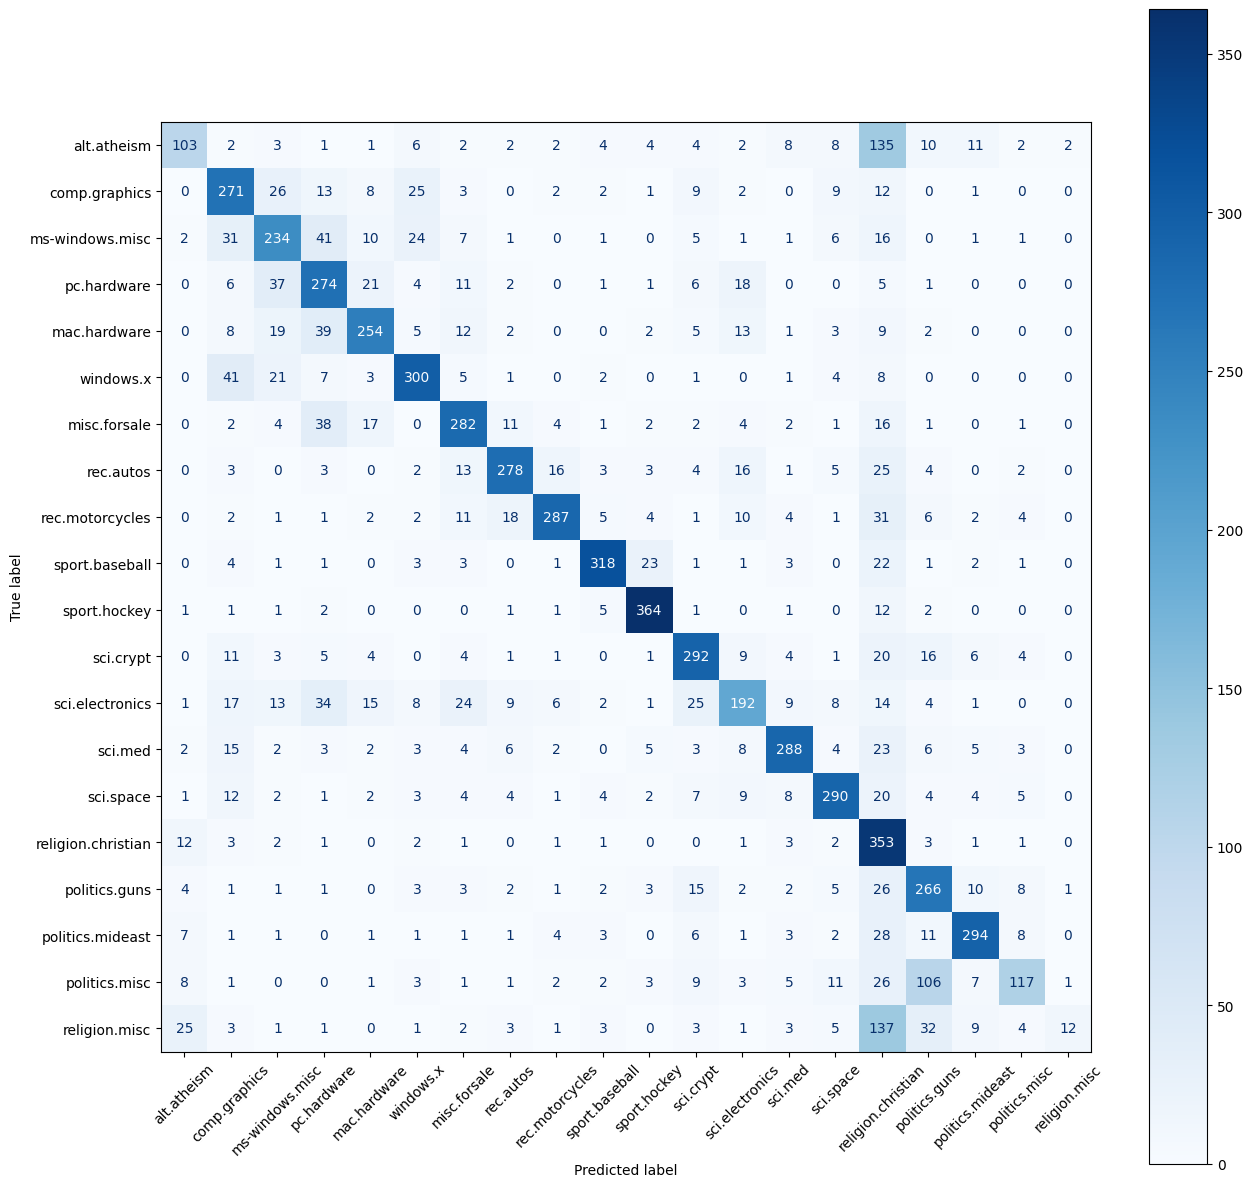

In [43]:
y_pred = cleaned_data_MNB.predict(cleaned_X_test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ConfusionMatrixDisplay(cm, display_labels=[".".join((l.split(".")[-2:])) for l in train.target_names]).plot(cmap="Blues", ax=ax)
plt.gca().spines[["right", "top"]].set_visible(True)
plt.xticks(rotation=45);

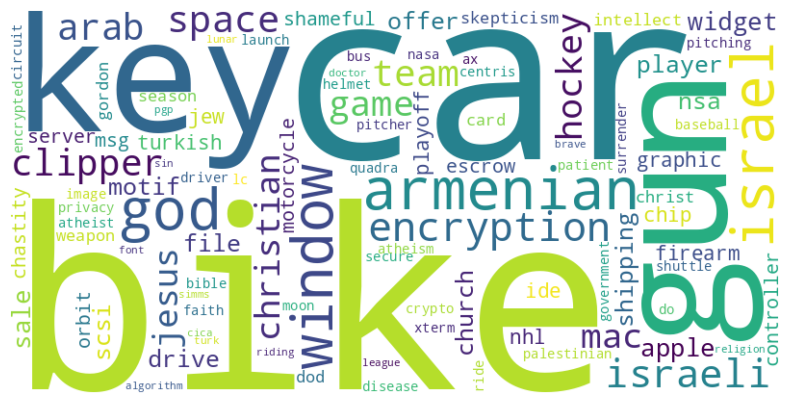

In [44]:
pipeline = cleaned_data_MNB

selector = pipeline.named_steps['selector']
vectorizer = pipeline.named_steps['vectorizer']

feature_names = np.asarray(vectorizer.get_feature_names_out())
top_indices = np.argsort(selector.scores_)[-100:]

top_features = feature_names[top_indices]
top_scores = selector.scores_[top_indices]

feature_scores = dict(zip(top_features, top_scores))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(feature_scores)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()